# Beating the Odds: An analysis of efficiency of betting markets in the English Premier League

The English Premier League has always been accompanied by the tradition of betting. Numerous bookkeepers, now mostly online, offer betting odds that express the probability of winners and losers. This analyis looks into betting odds from 2009 to 2019 for matches in the English Premiier League, placed on the most popular betting website Bet365.

I chose this betting site as it was the only site where data was consitently available for all years in the timeframe. Data was sourced from [[1]](#datahub).

Academic research [[2]](#dechamps) is interested in the favourites-longshot bias, i.e. whether betters are biased towards betting on longshots excessively in proportion to their actual win rate. We take this into account in our research questions for this analysis, which are as follows.

* How often were betting markets wrong about the predicted result?
* How has the error rate, defined as betting odds not matching the actual outcomes, evolved over the years; Have betting markets become better at predicting the actual winners over time?
* Which team is the most predictable & unpredictable team?

## Executive Summary
This analysis finds the following conclusions:
* Over the period 2009-2019, betting markets predicted the winner correctly 54.7% of the time.
* Over the period 2009-2019, betting markets very slightly improved at predicting the correct result.
* The most <strong>predictable</strong> teams in the period 2009-2019 were Manchester City, Portsmouth, Manchester United, Arsenal and Huddersfield. The most <strong>unpredicateble</strong> teams were West Brom, Blackpool, Southhampton, Wolves and Everton.


## Approach
The general approach taken is as follows.

1. The provided dataset is first brought into the right shape by stripping data that is not necessary for this analysis. The pared-down dataset is further normalized by standardizing dates to a uniform format.
2. For all matches in the dataset, we determine the projected and actual winners/losers based on the match result and and the betting odds, and add these to the dataset for further analysis.
3. Based on the extended dataset, we begin to answer the research questions above by plotting the data in charts.


## Part 1: Data Preparation

We import the requisite packages and load the data. Because the data is presented in separate files for each year from 2009 to 2019, we stitch together the files into a single dataframe. I decided to use CSV over JSON (both formats were available) as the data does not present any special hierarchy that may be of use. A flat CSV file suffices for our purposes.

In [15]:
import pandas as pd
import glob
from dateutil.parser import parse

matches = []
for infile in glob.glob("data/*.csv"):
    data = pd.read_csv(infile)
    matches.append(data)
matches = pd.concat(matches, ignore_index=True)

matches.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,LBA,SJH,SJD,SJA,BSH,BSD,BSA,SBH,SBD,SBA
0,E0,10/08/2018,Man United,Leicester,2,1,H,1,0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E0,11/08/2018,Bournemouth,Cardiff,2,0,H,1,0,H,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E0,11/08/2018,Fulham,Crystal Palace,0,2,A,0,1,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E0,11/08/2018,Huddersfield,Chelsea,0,3,A,0,2,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E0,11/08/2018,Newcastle,Tottenham,1,2,A,1,2,A,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Reducing the data set
It is clear that the dataframe contains many empty fields. Upon further inspection, these are other betting markets that do not have data for certain years. We pare down the data set to the columns we require:
* Date of the match
* Home Team
* Away Team
* Goals by the Home Team at Full Time ("FTHG")
* Goals by the Away Team at Full Time ("FTHG")
* Bet365.com odds for the home team winning ("B365H")
* Bet365.com odds for a draw ("B365D")
* Bet365.com odds for the away team winning ("B365A")

In [16]:
matches = matches[['Date', 'HomeTeam','AwayTeam','FTHG','FTAG','B365H','B365D','B365A']].copy()

matches

,Date,HomeTeam,AwayTeam,FTHG,FTAG,B365H,B365D,B365A
0,10/08/2018,Man United,Leicester,2,1,1.57,3.9,7.50
1,11/08/2018,Bournemouth,Cardiff,2,0,1.90,3.6,4.50
2,11/08/2018,Fulham,Crystal Palace,0,2,2.50,3.4,3.00
3,11/08/2018,Huddersfield,Chelsea,0,3,6.50,4.0,1.61
4,11/08/2018,Newcastle,Tottenham,1,2,3.90,3.5,2.04
...,...,...,...,...,...,...,...,...
3795,2010-05-09,Everton,Portsmouth,1,0,1.29,5.5,11.00
3796,2010-05-09,Hull,Liverpool,0,0,6.50,3.8,1.57
3797,2010-05-09,Man United,Stoke,4,0,1.13,8.0,23.00
3798,2010-05-09,West Ham,Man City,1,1,4.00,3.6,1.91


### Normalizing Dates
Looking at the *Date* field, it seems that the format is not uniform across years. We convert these dates from their current string form to a `DateTime` object and sort the entire dataset by date, presenting the earlier matches first.

In [17]:
# Convert date strings to date objects
matches['Date'] = pd.to_datetime(matches['Date'], dayfirst=True)

# Sort the dataframe
matches.sort_values(by='Date', axis=0, ascending=True, ignore_index=True, inplace=True)

matches

,Date,HomeTeam,AwayTeam,FTHG,FTAG,B365H,B365D,B365A
0,2009-08-15,Wolves,West Ham,0,2,2.63,3.30,2.70
1,2009-08-15,Aston Villa,Wigan,0,2,1.67,3.60,5.50
2,2009-08-15,Blackburn,Man City,0,2,3.60,3.25,2.10
3,2009-08-15,Bolton,Sunderland,0,1,2.25,3.25,3.25
4,2009-08-15,Chelsea,Hull,2,1,1.17,6.50,21.00
...,...,...,...,...,...,...,...,...
3795,2019-05-12,Leicester,Chelsea,0,0,2.40,3.75,2.90
3796,2019-05-12,Liverpool,Wolves,2,0,1.30,6.00,11.00
3797,2019-05-12,Man United,Cardiff,0,2,1.28,6.50,11.00
3798,2019-05-12,Watford,West Ham,1,4,2.25,3.75,3.20


### Extending the Data
To determine the winner and loser of each match, we iterate over the matches and add a column value containing the winner and loser of each match.

In [18]:
for i, match in matches.iterrows():
    # If the home team won
    if match['FTHG'] > match['FTAG']:
        matches.loc[i, 'Actual Winner'] =  match['HomeTeam']
        matches.loc[i, 'Actual Loser'] =  match['AwayTeam']
    # If the away team won
    elif match['FTHG'] < match['FTAG']:
        matches.loc[i, 'Actual Winner'] =  match['AwayTeam']
        matches.loc[i, 'Actual Loser'] =  match['HomeTeam']
    # If it was a draw
    else:
        matches.loc[i, 'Actual Winner'] =  "DRAW"
        matches.loc[i, 'Actual Loser'] =  "DRAW"
        
matches.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,B365H,B365D,B365A,Actual Winner,Actual Loser
0,2009-08-15,Wolves,West Ham,0,2,2.63,3.30,2.70,West Ham,Wolves
1,2009-08-15,Aston Villa,Wigan,0,2,1.67,3.60,5.50,Wigan,Aston Villa
2,2009-08-15,Blackburn,Man City,0,2,3.60,3.25,2.10,Man City,Blackburn
3,2009-08-15,Bolton,Sunderland,0,1,2.25,3.25,3.25,Sunderland,Bolton
4,2009-08-15,Chelsea,Hull,2,1,1.17,6.50,21.00,Chelsea,Hull


We do the same for the projected winners and losers. For a team to be determined the projected winner, their odds need to be lower than both the draw odds, and the odds of the other team. We use the `min()` function to achieve this comparison.

In [19]:
for i, match in matches.iterrows():
    if match['B365H'] < min(match['B365A'],match['B365D']):
        matches.loc[i, 'Predicted Winner'] =  match['HomeTeam']
        matches.loc[i, 'Predicted Loser'] =  match['AwayTeam']
    elif match['B365A'] < min(match['B365H'],match['B365D']) :
        matches.loc[i, 'Predicted Winner'] =  match['AwayTeam']
        matches.loc[i, 'Predicted Loser'] =  match['HomeTeam']
    else:
        matches.loc[i, 'Predicted Winner'] =  "DRAW"
        matches.loc[i, 'Predicted Loser'] =  "DRAW"
        
matches.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,B365H,B365D,B365A,Actual Winner,Actual Loser,Predicted Winner,Predicted Loser
0,2009-08-15,Wolves,West Ham,0,2,2.63,3.30,2.70,West Ham,Wolves,Wolves,West Ham
1,2009-08-15,Aston Villa,Wigan,0,2,1.67,3.60,5.50,Wigan,Aston Villa,Aston Villa,Wigan
2,2009-08-15,Blackburn,Man City,0,2,3.60,3.25,2.10,Man City,Blackburn,Man City,Blackburn
3,2009-08-15,Bolton,Sunderland,0,1,2.25,3.25,3.25,Sunderland,Bolton,Bolton,Sunderland
4,2009-08-15,Chelsea,Hull,2,1,1.17,6.50,21.00,Chelsea,Hull,Chelsea,Hull


## Part 2: Data Analysis

We now begin with the analysis of the data. The first question we want to answer is:

* How often were betting markets wrong about the predicted result?

To answer this, we need to determine if the predicted winner matched up with the actual winner. We do this by adding a further column to our dataset.

In [20]:
for i, match in matches.iterrows():
    if match['Actual Winner'] == match['Predicted Winner']:
        matches.loc[i, 'Hit'] =  True
    else:
        matches.loc[i, 'Hit'] =  False
        
matches

,Date,HomeTeam,AwayTeam,FTHG,FTAG,B365H,B365D,B365A,Actual Winner,Actual Loser,Predicted Winner,Predicted Loser,Hit
0,2009-08-15,Wolves,West Ham,0,2,2.63,3.30,2.70,West Ham,Wolves,Wolves,West Ham,False
1,2009-08-15,Aston Villa,Wigan,0,2,1.67,3.60,5.50,Wigan,Aston Villa,Aston Villa,Wigan,False
2,2009-08-15,Blackburn,Man City,0,2,3.60,3.25,2.10,Man City,Blackburn,Man City,Blackburn,True
3,2009-08-15,Bolton,Sunderland,0,1,2.25,3.25,3.25,Sunderland,Bolton,Bolton,Sunderland,False
4,2009-08-15,Chelsea,Hull,2,1,1.17,6.50,21.00,Chelsea,Hull,Chelsea,Hull,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3795,2019-05-12,Leicester,Chelsea,0,0,2.40,3.75,2.90,DRAW,DRAW,Leicester,Chelsea,False
3796,2019-05-12,Liverpool,Wolves,2,0,1.30,6.00,11.00,Liverpool,Wolves,Liverpool,Wolves,True
3797,2019-05-12,Man United,Cardiff,0,2,1.28,6.50,11.00,Cardiff,Man United,Man United,Cardiff,False
3798,2019-05-12,Watford,West Ham,1,4,2.25,3.75,3.20,West Ham,Watford,Watford,West Ham,False


### Calculating the Hit Rate
We now calculate the percentage rate at which the "Hit" was true. We do this by grouping the dataset by the "Hit" value, counting the hits and applying a lambda function to calculate the percentage value.

This new small dataframe contains just the percentage values for where hits were true or false. We apply a further lambda function to format the percentage values properly.

In [21]:
# Group the data by 'hits'
hits = matches.groupby(matches['Hit'])['Predicted Winner']
hits = pd.DataFrame(hits.count())

# Calculate the percentage 'hit rate'
hits = hits.apply(lambda n: n/n.sum())

hits['Hit %'] = hits['Predicted Winner'].apply(lambda n: '{:.1%}'.format(n))
hits['Hit %']

Hit
False    45.3%
True     54.7%
Name: Hit %, dtype: object

### Research Result #1
<div style="background-color: #d6fedb; font-weight: bold">
Over the period 2009-2019, betting markets predicted the winner correctly 54.7% of the time.
</div>

We can plot this data to show the proportion of hits and misses. We use the `pie()` method in `matplotlib` t0 achieve this.

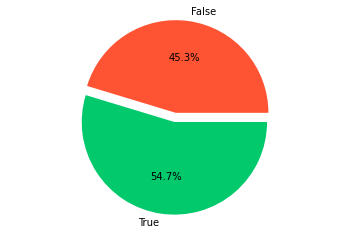

In [22]:
import matplotlib.pyplot as plt

# Data to plot
labels = hits.index.values
sizes = hits['Predicted Winner']
colors = ['#ff5433', '#03c96d']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%')

plt.axis('equal')
plt.show()

### Analyzing the hit rate over time

The next question to answer is:

* How has the error rate, defined as betting odds not matching the actual outcomes, evolved over the years; Have betting markets become better at predicting the actual winners over time?

To answer this, we assemble a crosstab of the years and the normalized hit rates. This quickly gives us the percentage values of hits and misses per year.

In [23]:
yearly_hits = pd.crosstab([matches['Date'].dt.year], [matches['Hit']], normalize='index')
yearly_hits

Hit,False,True
Date,,
2009,0.448980,0.551020
2010,0.478610,0.521390
2011,0.466844,0.533156
2012,0.488491,0.511509
2013,0.443548,0.556452
2014,0.407895,0.592105
2015,0.518421,0.481579
2016,0.462963,0.537037
2017,0.396509,0.603491


Plotting this data as a stacked bar chart will show us the evolution over time visually.

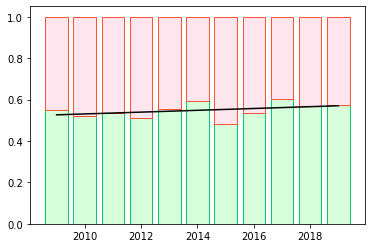

In [24]:
import numpy as np

# Get the data for plotting
years = yearly_hits.index.values
hitData = yearly_hits[True].values
missData = yearly_hits[False].values

# Plot the bar chart
plt.bar(years, hitData, color='#d6fedb', edgecolor='#03c96d')
plt.bar(years, missData, bottom=hitData, color='#ffe5ed', edgecolor='#ff5433')

# Create and plot a regression line
m,b = np.polyfit(years, hitData, 1)
plt.plot(years, m*years + b, color='black')

### Research Result #2
<div style="background-color: #d6fedb; font-weight: bold">
Over the period 2009-2019, betting markets very slightly improved at predicting the correct result.
</div>

### Team Predicatability

The final research question we aim to answer is:
* Which team is the most predictable & unpredictable team?
To answer this question, we will define a team as completely predictable if the all predictions for that team (Winner, Draw, Loser) were correct, and completely unpredictable if all predictions for that team (Winner, Draw, Loser) were incorrect. Hence we will calculate the percentage at which predictions were true for all teams.

We will further constrain the data to teams that have been in the premier league for at least 3 seasons. This means we will use teams only if they have played at least 114 matches.

Because team data is listed either as the home team of the away team, we need to create two crosstabs (Home and Away) and combine them to get the total number of hits and misses per team.

In [25]:
# Create a sorted crosstab of Home Team data and rename the Home Team column name
team_hits_home = pd.crosstab(matches['HomeTeam'], matches['Hit'])
team_hits_home.sort_values(by=[True], inplace=True, ascending=False)
team_hits_home['Total']= team_hits_home[True] + team_hits_home[False]
team_hits_home.index.name = "Team"
team_hits_home

# Create a sorted crosstab of Away Team data and rename the Away Team column name
team_hits_away = pd.crosstab(matches['AwayTeam'], matches['Hit'])
team_hits_away.sort_values(by=[True], inplace=True, ascending=False)
team_hits_away['Total']= team_hits_home[True] + team_hits_home[False]
team_hits_away.index.name = "Team"

# Merge the two dataframes and filter for teams that have played at least 114 matches (3 seasons)
team_hits = team_hits_away + team_hits_home
team_hits.sort_values(by='Total',inplace=True,ascending=False)
team_hits[team_hits['Total'] > 114]

Hit,False,True,Total
Team,,,
Arsenal,143,237,380
Chelsea,151,229,380
Tottenham,151,229,380
Man United,141,239,380
Liverpool,171,209,380
Everton,193,187,380
Man City,127,253,380
West Ham,173,169,342
Stoke,176,166,342


We will convert this dataset to represent percentage values.

In [26]:
team_hits_pc = team_hits.copy()
team_hits_pc[False] = (team_hits_pc[False] / team_hits_pc['Total']).round(2)
team_hits_pc[True] = (team_hits_pc[True] / team_hits_pc['Total']).round(2)
team_hits_pc['Total'] = team_hits_pc[False] + team_hits_pc[True]
team_hits_pc.sort_values(by=True,inplace=True,ascending=False)
team_hits_pc.head()

Hit,False,True,Total
Team,,,
Man City,0.33,0.67,1.0
Portsmouth,0.37,0.63,1.0
Man United,0.37,0.63,1.0
Arsenal,0.38,0.62,1.0
Huddersfield,0.38,0.62,1.0


In [27]:
team_hits_pc.sort_values(by=True,inplace=True,ascending=True)
team_hits_pc.head()

Hit,False,True,Total
Team,,,
West Brom,0.54,0.46,1.0
Blackpool,0.53,0.47,1.0
Southampton,0.53,0.47,1.0
Wolves,0.52,0.48,1.0
Everton,0.51,0.49,1.0


### Research Result #3
<div style="background-color: #d6fedb">
    The most <strong>predictable</strong> teams in the period 2009-2019 were Manchester City, Portsmouth, Manchester United, Arsenal and Huddersfield. The most <strong>unpredicateble</strong> teams were West Brom, Blackpool, Southhampton, Wolves and Everton.
</div>

This result posits a further hypothesis for investigation: 3 of the top 5 most predictable teams are also teams that have won the league in the last 10 years. Hence, a further point of analysis might be the correlation between the rate of winning and the predictability of the result, as this confirms the research that indicates a favourites-bias in betting odds.

# Appendix
## Git Log

In [29]:
!git log --oneline --decorate --graph --all

* 685a1b8 (HEAD -> master, origin/master) Midterm report complete
* 42ec993 Research Question 3 answered
* 2b35f21 Research Question 2 answered
* bd904de Data Preparation and Research Question 1 answered
* cd22541 Data ingested and setup ininitial prototype of analysis
* b917b7d NumPy and Pandas basics done
* ed0ed44 Basic NumPy done
*   99e9f9d Merge branch 'master' of https://github.com/arjunmuralidharan/CM2015_PWD
|\  
| * ec236de Fixed an issue in section 'Working with Files'
* | d35a47a Improved 3.08 tokenizer code
|/  
* 97a3d65 Exercises Weeks 1-5 complete and summary updated
* f6710b7 Week 3 summary complete
* 35d41e3 Prepare for Binder Deployment
* 75ea11b Summary as Jupyter Notebook
* d6b0e08 Week 1 notes complete
* e4e7a60 Initial commit. Summary set up with first notes.


## References


<a name="datahub"></a>[1]: https://www.datahub.io/sports-data/english-premier-league

<a name="dechamps"></a>[2]: Deschamps, Bruno & Gergaud, Olivier. (2007). [Efficiency in Betting Markets: Evidence From English Football](https://www.researchgate.net/publication/291191792_Efficiency_in_Betting_Markets_Evidence_From_English_Football). The Journal of Prediction Markets. 1. 61-73. 10.5750/jpm.v1i1.420. 